<a href="https://colab.research.google.com/github/EVA4-RS-Group/Phase2/blob/master/S4_FaceRecognition/EVA4_P2_S4_Face_Recognition_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Loading standard Libraries and project modules


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Load modules/models from EVA course
!pip install torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!rm -rf Modules
!rm -rf models
!git clone https://github.com/EVA4-RS-Group/Phase2 -q --quiet
!mv ./Phase2/Modules ./Modules
!mv /content/Phase2/S4_FaceRecognition/models /content/

!rm -rf Phase2

#print("Loaded EVA4 Modules")
from Modules import *

# 2. Load Data & Set Data Loaders

In [3]:
# Downloading dataset and unziping into proper folder structure
!rm -rf Data_*.zip
!rm -rf Data_Processed
!rm -rf data

!wget -q https://github.com/EVA4-RS-Group/Phase2/releases/download/S4/Data_v2_Processed.zip
!unzip -q Data_v2_Processed.zip

## 2.1 Load images in to DataSet and also perform data transforms

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data = LoadFaceDataset('/content/Data_Processed', batch_size = 8)

['AishwaryaRai', 'Alejandro_Toledo', 'Alvaro_Uribe', 'Amelie_Mauresmo', 'Andre_Agassi', 'Angelina_Jolie', 'Ariel_Sharon', 'Arnold_Schwarzenegger', 'Atal_Bihari_Vajpayee', 'Bill_Clinton', 'Carlos_Menem', 'Colin_Powell', 'David_Beckham', 'Donald_Rumsfeld', 'ElonMusk', 'George_Robertson', 'George_W_Bush', 'Gerhard_Schroeder', 'Gloria_Macapagal_Arroyo', 'Gray_Davis', 'Guillermo_Coria', 'Hamid_Karzai', 'Hans_Blix', 'Hugo_Chavez', 'Igor_Ivanov', 'Jack_Straw', 'Jacques_Chirac', 'Jean_Chretien', 'Jennifer_Aniston', 'Jennifer_Capriati', 'Jennifer_Lopez', 'Jeremy_Greenstock', 'Jiang_Zemin', 'John_Ashcroft', 'John_Negroponte', 'Jose_Maria_Aznar', 'Juan_Carlos_Ferrero', 'Junichiro_Koizumi', 'Kofi_Annan', 'Laura_Bush', 'Lindsay_Davenport', 'Lleyton_Hewitt', 'Luiz_Inacio_Lula_da_Silva', 'MahendraSinghDhoni', 'Mahmoud_Abbas', 'MalalaYousafzai', 'Megawati_Sukarnoputri', 'Michael_Bloomberg', 'Naomi_Watts', 'NarendraModi', 'Nestor_Kirchner', 'Paul_Bremer', 'Pete_Sampras', 'PriyankaChopra', 'RahulGandhi'

# 3. Visualize a few images
Let’s visualize a few training images so as to understand the data augmentations.

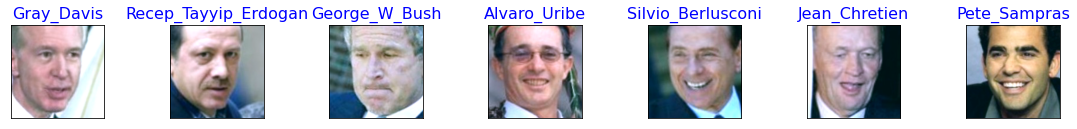

In [5]:
data.show_batch(save_as="sample.jpg")

# 4. Defining the pre-trained inception network and customize its layer

In [10]:
import torch.optim as optim
from models.inception_resnet_v1 import InceptionResnetV1
#from torch_lr_finder import LRFinder

print('Running on device: {}'.format(device))
model_ft = InceptionResnetV1(pretrained='vggface2', classify=False, num_classes = len(data.class_names))
#print(model_ft)

#Remove the last layers after conv block and place in layer_list .
layer_list = list(model_ft.children())[-5:] # all final layers
layer_list

Running on device: cuda:0


[AdaptiveAvgPool2d(output_size=1),
 Dropout(p=0.6, inplace=False),
 Linear(in_features=1792, out_features=512, bias=False),
 BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=512, out_features=8631, bias=True)]

In [11]:
# Put all beginning layers in an nn.Sequential . 
# model_ft is now a torch model but without the final linear, pooling, batchnorm, and sigmoid layers.
model_ft = nn.Sequential(*list(model_ft.children())[:-5])

# Setting gradient off for parameters of remaining base layers 
for param in model_ft.parameters():
  param.requires_grad = False

In [12]:
from models.inception_adder import *

# Adding last layers for our purpose
model_ft.avgpool_1a = nn.AdaptiveAvgPool2d(output_size=1)
model_ft.last_linear = nn.Sequential(
    Flatten(),
    nn.Linear(in_features=1792, out_features=512, bias=False),
    normalize()
)
model_ft.logits = nn.Linear(layer_list[4].in_features, len(data.class_names))
#model_ft.softmax = nn.Softmax(dim=1)
model_ft = model_ft.to(device)

# 5. Training Mobilenet Model - Only last layers

## 5.1 Find hyper parameter lr value using LR Finder


Learning rate search finished. See the graph with {finder_name}.plot()


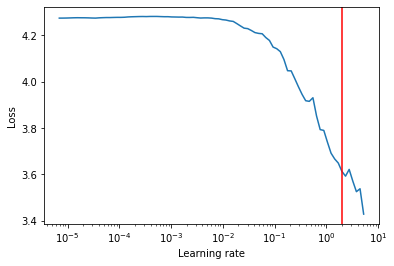

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=1e-6, weight_decay=0.01,momentum=0.9)
lr_finder = LRFinder(model_ft, optimizer, criterion, device="cuda")
lr_finder.range_test(data.dataloaders['train'], end_lr=10, num_iter=100)
lr_finder.plot(show_lr=2.0) # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial stat

In [14]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.09, weight_decay=1e-4)

scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                          max_lr=2.0, 
                                          steps_per_epoch=len(data.dataloaders['train']), #Training folder size/bs 
                                          epochs=300,final_div_factor=1e5)

In [15]:
#from Modules import *
model_res, FT_losses = train_face_recog_model(model_ft, data, device, criterion, optimizer_ft, scheduler,
                       num_epochs=300)

Epoch 0/29
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 4.1013 Acc: 0.2357
val Loss: 3.9452 Acc: 0.2487
Epoch 1/29
----------
train Loss: 3.8395 Acc: 0.2551
val Loss: 3.7256 Acc: 0.2367
Epoch 2/29
----------
train Loss: 3.6444 Acc: 0.2470
val Loss: 3.5541 Acc: 0.2487
Epoch 3/29
----------
train Loss: 3.4930 Acc: 0.2434
val Loss: 3.4179 Acc: 0.2477
Epoch 4/29
----------
train Loss: 3.3720 Acc: 0.2470
val Loss: 3.3125 Acc: 0.2578
Epoch 5/29
----------
train Loss: 3.2822 Acc: 0.2591
val Loss: 3.2320 Acc: 0.2790
Epoch 6/29
----------
train Loss: 3.2065 Acc: 0.2672
val Loss: 3.1596 Acc: 0.2769
Epoch 7/29
----------
train Loss: 3.1395 Acc: 0.2820
val Loss: 3.0987 Acc: 0.2971
Epoch 8/29
----------
train Loss: 3.0815 Acc: 0.2923
val Loss: 3.0451 Acc: 0.2920
Epoch 9/29
----------
train Loss: 3.0328 Acc: 0.3076
val Loss: 2.9958 Acc: 0.3182
Epoch 10/29
----------
train Loss: 2.9885 Acc: 0.3202
val Loss: 2.9541 Acc: 0.3122
Epoch 11/29
----------
train Loss: 2.9448 Acc: 0.3305
val Loss: 2.9118 Acc: 0.3323
Epoch 12/29
----------
train Loss: 2

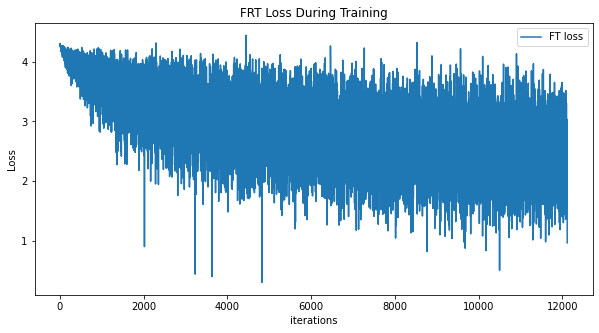

In [16]:
plt.figure(figsize=(10,5))
plt.title("FRT Loss During Training")
plt.plot(FT_losses, label="FT loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

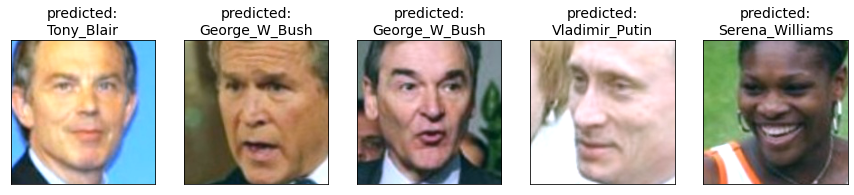

In [19]:
visualize_model(model_res, data, device,"visualize_2.jpg")
plt.show()

# 8. Saving Model

In [20]:
# Save GPU Model
torch.save(model_res.state_dict(), '/content/inception_resnet_face_recog_gpu_v2.pt')

In [21]:
# Load CPU Model
device = torch.device('cpu')
model = InceptionResnetV1(pretrained='vggface2', classify=False, num_classes = len(data.class_names))

# Put all beginning layers in an nn.Sequential . 
# model_ft is now a torch model but without the final linear, pooling, batchnorm, and sigmoid layers.
model = nn.Sequential(*list(model.children())[:-5])

# Adding last layers for our purpose
model.avgpool_1a = nn.AdaptiveAvgPool2d(output_size=1)
model.last_linear = nn.Sequential(
    Flatten(),
    nn.Linear(in_features=1792, out_features=512, bias=False),
    normalize()
)
model.logits = nn.Linear(layer_list[4].in_features, len(data.class_names))


model.load_state_dict(torch.load('/content/inception_resnet_face_recog_gpu_v2.pt',
                                 map_location=device))

<All keys matched successfully>

In [22]:
# Saving Trace Model
model.eval()
# trace model with a dummy input
traced_model = torch.jit.trace(model, torch.randn(1, 3, 160, 160))
traced_model.save('inception_resnet_face_recog_v2.pt')